### Imports

In [2]:
import cv2
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

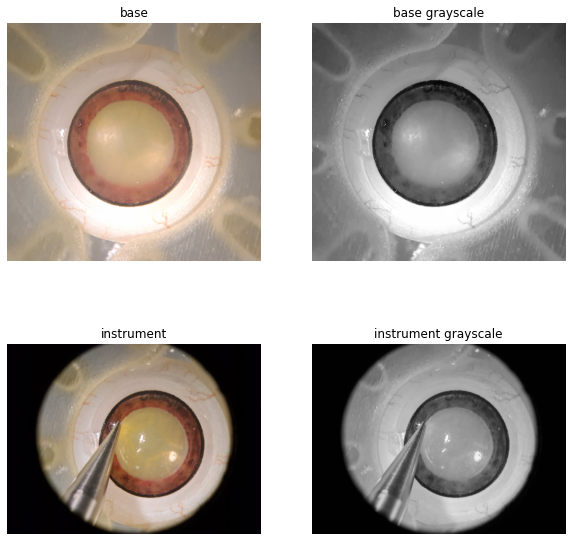

In [17]:
base = cv2.imread('data/artificial/base2.jpeg', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

instrument = cv2.imread('data/artificial/instrument.jpeg', cv2.IMREAD_COLOR)
instrument_rgb = cv2.cvtColor(instrument, cv2.COLOR_BGR2RGB)
instrument_gray = cv2.cvtColor(instrument, cv2.COLOR_BGR2GRAY)
instrument_hsv = cv2.cvtColor(instrument, cv2.COLOR_BGR2HSV)

fig, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2, figsize=(10,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('instrument')
plot3.imshow(instrument_rgb)
plot3.axis('off')

plot4.set_title('instrument grayscale')
plot4.imshow(instrument_gray, cmap=plt.cm.gray)
plot4.axis('off')

plt.show()

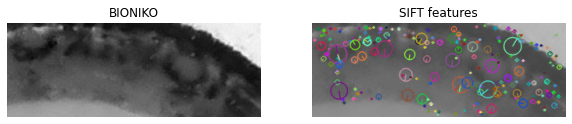

In [18]:
bioniko_gray = base_gray[395:515,695:1020]

sift = cv2.SIFT_create(contrastThreshold=0.01)
sift_keypoints = sift.detect(bioniko_gray, None) # a mask can be passed

bioniko_sift = cv2.drawKeypoints(bioniko_gray, sift_keypoints, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,5))
plot1.set_title('BIONIKO')
plot1.imshow(bioniko_gray, cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('SIFT features')
plot2.imshow(cv2.cvtColor(bioniko_sift, cv2.COLOR_BGR2RGB))
plot2.axis('off')

plt.show()

### BIONIKO marking detection

#### SIFT

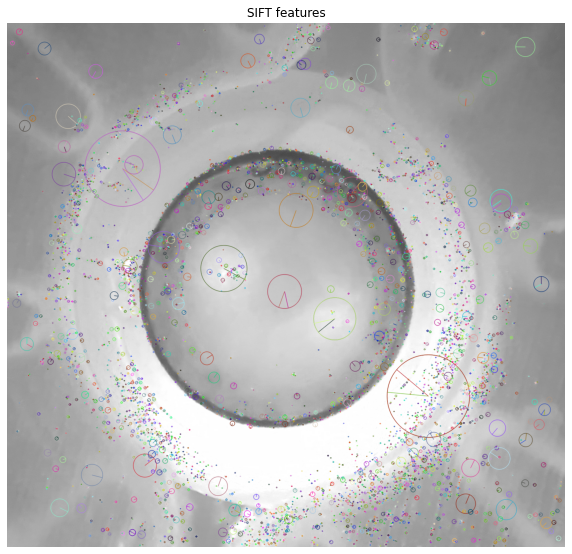

In [19]:
sift = cv2.SIFT_create(contrastThreshold=0.01)
sift_keypoints = sift.detect(base_hsv[:,:,2], None) # a mask can be passed

base_sift = cv2.drawKeypoints(base_hsv[:,:,2], sift_keypoints, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, plot1 = plt.subplots(1, 1, figsize=(10,10))
plot1.set_title('SIFT features')
plot1.imshow(cv2.cvtColor(base_sift, cv2.COLOR_BGR2RGB))
plot1.axis('off')

plt.show()

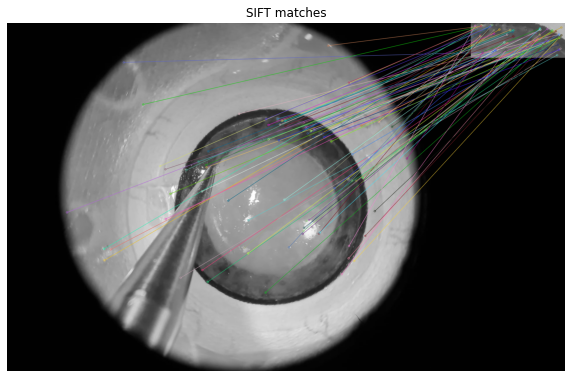

In [20]:
sift = cv2.SIFT_create(contrastThreshold=0.01)

instrument_sift_keypoints, instrument_sift_desc = sift.detectAndCompute(instrument_gray, None)
bioniko_sift_keypoints, bioniko_sift_desc = sift.detectAndCompute(bioniko_gray, None)

bf_matcher = cv2.BFMatcher()
matches = bf_matcher.knnMatch(instrument_sift_desc, bioniko_sift_desc, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

img_matches = cv2.drawMatchesKnn(
    instrument_gray, instrument_sift_keypoints,
    bioniko_gray, bioniko_sift_keypoints,
    good, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

fig, plot1 = plt.subplots(1, 1, figsize=(10,10))
plot1.set_title('SIFT matches')
plot1.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plot1.axis('off')

plt.show()

#### Rigid transform estimation with RANSAC on SIFT feature matches

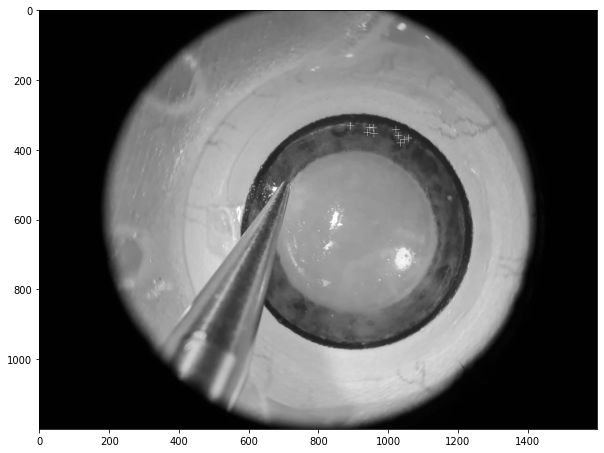

In [21]:
instrument_good_points = []
bioniko_good_points = []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        instrument_good_points.append(instrument_sift_keypoints[m.queryIdx].pt)
        bioniko_good_points.append(bioniko_sift_keypoints[m.trainIdx].pt)

instrument_good_points = np.array(instrument_good_points)
bioniko_good_points = np.array(bioniko_good_points)

transform, inliers = cv2.estimateAffinePartial2D(
    instrument_good_points,
    bioniko_good_points
)

inliers_matches = instrument_gray.copy()
for pt in instrument_good_points[np.where(inliers == 1)[0],:]:
    cv2.drawMarker(inliers_matches, tuple(pt.astype('int')), 255)

fig, plot1 = plt.subplots(1, 1, figsize=(10,10))
plot1.imshow(inliers_matches, cmap=plt.cm.gray)

plt.show()


#### ORB

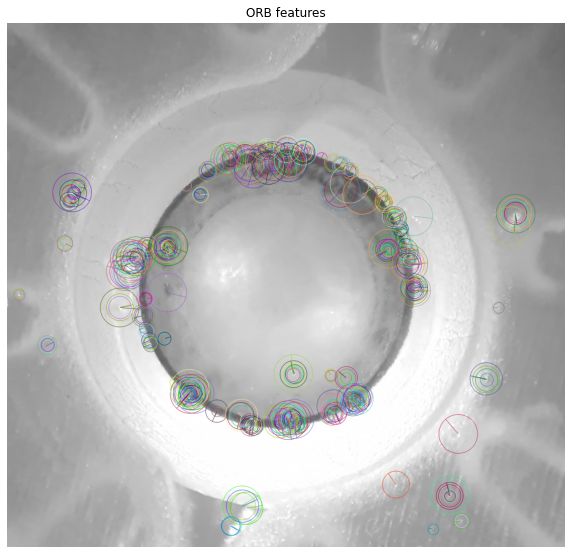

In [97]:
orb = cv2.ORB_create()
orb_keypoints = orb.detect(base_hsv[:,:,2], None) # a mask can be passed

base_orb = cv2.drawKeypoints(base_hsv[:,:,2], orb_keypoints, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, plot1 = plt.subplots(1, 1, figsize=(10,10))
plot1.set_title('ORB features')
plot1.imshow(cv2.cvtColor(base_orb, cv2.COLOR_BGR2RGB))
plot1.axis('off')

plt.show()

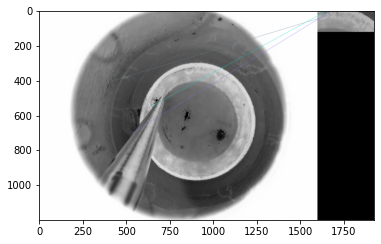

(<matplotlib.image.AxesImage at 0x7fa8ef78b0d0>, None)

In [98]:
orb = cv2.ORB_create()

instrument_orb_keypoints, instrument_orb_desc = orb.detectAndCompute(instrument_gray, None)
bioniko_orb_keypoints, bioniko_orb_desc = orb.detectAndCompute(bioniko_gray, None)

bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf_matcher.match(instrument_orb_desc, bioniko_orb_desc)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(
    instrument_gray, instrument_sift_keypoints,
    bioniko_gray, bioniko_sift_keypoints,
    matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()


#### other methods

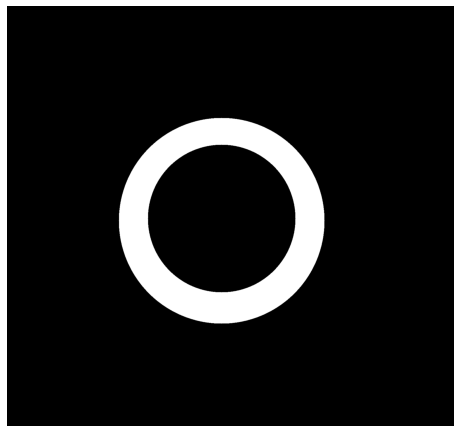

In [3]:
iris_mask = cv2.imread('data/artificial/base2_iris_mask.png', cv2.IMREAD_COLOR)
iris_mask = cv2.cvtColor(iris_mask, cv2.COLOR_BGR2GRAY)

fig, plot1 = plt.subplots(1, 1, figsize=(8,8))
plot1.imshow(iris_mask, cmap=plt.cm.gray)
plot1.axis('off')

plt.show()

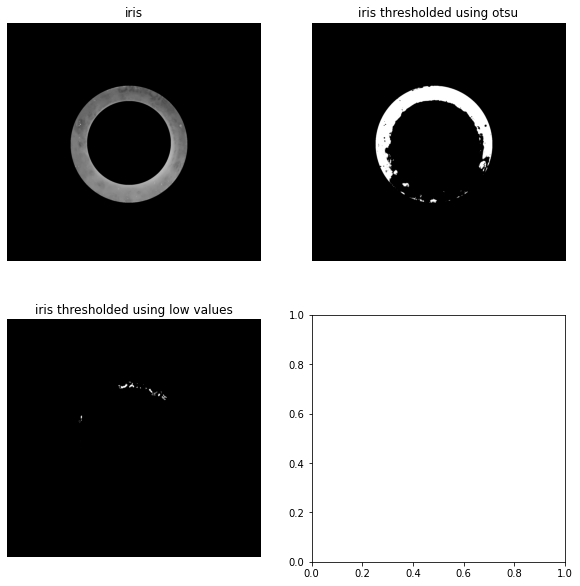

In [4]:
thresh_percentage = 0.01

iris_values = base_gray[np.where(iris_mask == 255)[0],np.where(iris_mask == 255)[1]]
thres_otsu, _ = cv2.threshold(
    src=iris_values,
    thresh=0,
    maxval=255,
    type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
)

iris_otsu = base_gray.copy()
_, iris_otsu = cv2.threshold(iris_otsu, thresh=thres_otsu, maxval=255, type=cv2.THRESH_BINARY_INV)
iris_otsu = cv2.bitwise_and(iris_otsu, iris_mask)

low_thres = np.sort(iris_values)[int(thresh_percentage * iris_values.size)]
iris_low = base_gray.copy()
_, iris_low = cv2.threshold(iris_low, thresh=low_thres, maxval=255, type=cv2.THRESH_BINARY_INV)
iris_low = cv2.bitwise_and(iris_low, iris_mask)

fig, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2, figsize=(10,10))
plot1.set_title('iris')
plot1.imshow(cv2.bitwise_and(base_gray, iris_mask), cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('iris thresholded using otsu')
plot2.imshow(iris_otsu, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('iris thresholded using low values')
plot3.imshow(iris_low, cmap=plt.cm.gray)
plot3.axis('off')

plt.show()

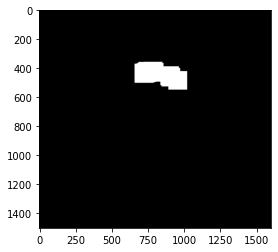

In [6]:
kernel = np.ones((7,7), dtype=np.uint8)

morphed = iris_low.copy()
morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
morphed = cv2.dilate(morphed, kernel, iterations=20)

plt.imshow(morphed, cmap=plt.cm.gray)

In [8]:
cv2.imwrite('test.png', morphed)

True

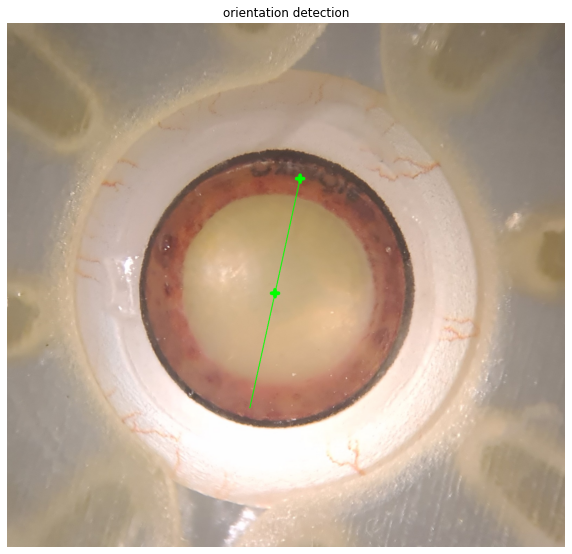

In [9]:
iris_center = np.mean(np.array(np.where(iris_mask == 255)), axis=1)
iris_center = np.uint16(np.flip(iris_center))

bioniko_center = np.mean(np.array(np.where(morphed == 255)), axis=1)
bioniko_center = np.uint16(np.flip(bioniko_center))

orientation = bioniko_center - iris_center
start_point = iris_center + orientation
end_point = iris_center - orientation

base_with_orientation = base.copy()
cv2.drawMarker(base_with_orientation, tuple(iris_center), (0, 255, 0), thickness=10)
cv2.drawMarker(base_with_orientation, tuple(bioniko_center), (0, 255, 0), thickness=10)
cv2.line(
    base_with_orientation,
    tuple(start_point),
    tuple(end_point),
    [0, 255, 0], thickness=2
)

fig, plot1 = plt.subplots(1, 1, figsize=(10,10))
plot1.set_title('orientation detection')
plot1.imshow(cv2.cvtColor(base_with_orientation, cv2.COLOR_BGR2RGB))
plot1.axis('off')

plt.show()

In [11]:
cv2.imwrite('test.png', base_with_orientation)

True

#### further ideas
- morphological preprocessing steps (erosion, etc.) before localizing the 'BIONIKO' marker to for black ring removal
- analysis regarding the threshold choice (or multiple) to segment the 'BIONIKO' marker
- robust 0th degree determination (starting from centroid)